# Quantifying watermass conversion in the Labrador Sea in the VIKING20X model.

Change in volume with time by density level

[This notebook takes a while to run]


## Technical preample

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
import seawater as sw
from xhistogram.xarray import histogram


import seaborn as sns
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/

In [2]:
sns.set(style="darkgrid")

xr.set_options(keep_attrs=True)
np.warnings.filterwarnings('ignore')

sns.set_palette("colorblind")
xr.set_options(keep_attrs=True);

plt.rc('font', size=14) #controls default text size
plt.rc('axes', titlesize=14) #fontsize of the title
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('xtick', labelsize=14) #fontsize of the x tick labels
plt.rc('ytick', labelsize=14) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend
plt.rc('savefig', dpi=300)       # higher res outputs

In [3]:
plt.rcParams['figure.figsize'] = [9, 7]
plt.rcParams.update({'font.size': 17})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")

In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=48e9)
client

Client Scheduler: tcp://127.0.0.1:32929 Dashboard: /user/workshop007/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 48.00 GB


_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [6]:
# paramters
# Project path
path_project = Path.cwd() / '..' / '..' 
path_project = path_project.resolve()


# path to osnap section definition
sectionPath = path_project / 'data' / 'external'
sectionFilename = 'osnap_pos_wp.txt'
sectionname = 'osnap'

# output data path
path_data_output = path_project / 'data/interim/watermassBudget/volumeBudget'


global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"

mean_period = "1m"
year = 1990

In [7]:
yearstr = str(year)

## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [8]:
T_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_{mean_period}_{yearstr}????_{yearstr}????_grid_T.nc")
T_files = list(sorted(T_files))
print(f"found {len(T_files)} grid-T files")

mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mask*.nc")
mask_files = list(sorted(mask_files))
print(f"found {len(mask_files)} mask files")

mesh_mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")


found 1 grid-T files
found 1 mask files
found 1 mesh mask files


In [9]:
gridT = xr.open_mfdataset(
    T_files,
    chunks={
        "time_counter": 1, "deptht": 1,
        "y": 256, "x": 1024
    },
    combine='by_coords'
)
mask = xr.open_dataset(mask_files[0],
    chunks={
        "t": 1, "z": 1,
        "y": 256, "x": 1024
    },
)
mesh_mask = xr.open_dataset(mesh_mask_files[0],
    chunks={
        "z": 1,
        "y": 256, "x": 1024
    },
)

## Define a section and find grid points along the section

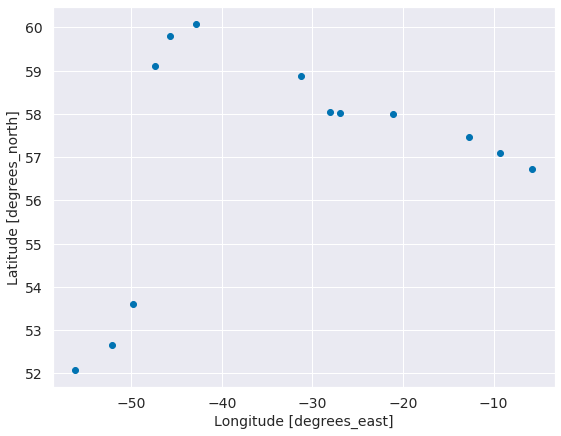

In [10]:

lonlat = xr.Dataset(pd.read_csv(sectionPath / sectionFilename,delim_whitespace=True))

lonlat

lonlat.lon.attrs['long_name']='Longitude'
lonlat.lat.attrs['long_name']='Latitude'
lonlat.lon.attrs['standard_name']='longitude'
lonlat.lat.attrs['standard_name']='latitude'
lonlat.lon.attrs['units']='degrees_east'
lonlat.lat.attrs['units']='degrees_north'

lonlat.plot.scatter(x='lon',y='lat')

ll_points = np.vstack((lonlat.lat.data, lonlat.lon.data)).T
ll_points = ll_points[0:6]

## Find related indices

This takes an inordinate amount of time, because `get_ij` will transform grid points on the (spherical) earth to 3D, and do the nearest-neighbor-lookup there. There are faster ways. Probably more efficient for many points.

In [11]:
# # no need to run this every time, just save the coordinates for later. (WARNING: not working on reduce array)

# vertices_ji = get_ij(
#     mesh_mask,
#     ll_points,
#     grid="f",
#     xgcm=False,
#     xarray_out=False
# )

In [12]:
vertices_ji = np.array([[1959,870],
 [1969,  950],
 [1995, 998],
 [2172, 1067],
 [2192, 1099],
 [2194, 1152],
 [2139, 1352],
 [2111, 1410],
 [2109, 1429],
 [2110, 1533],
 [2103, 1685],
 [2097, 1747],
 [2093, 1812]])



### Cut out small area
To speed calculations

In [13]:
xmin=600
xmax=1200
ymin=1900
ymax=None

In [14]:
gridT = gridT.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))
mask = mask.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))
mesh_mask = mesh_mask.isel(x=slice(xmin,xmax,1),y=slice(ymin,ymax,1))

In [37]:
mesh_mask.e3t_0.isel(x=300,y=300).compute()

<xarray.DataArray 'e3t_0' (z: 46)>
array([  6.19056967,   6.64035315,   7.1997574 ,   7.89479515,
         8.75726687,   9.82583868,  11.14720478,  12.77726958,
        14.78223443,  17.2394034 ,  20.23743024,  23.8756176 ,
        28.2617659 ,  33.50798459,  39.72388261,  47.00672916,
        55.4286164 ,  65.02142117,  75.76140926,  87.55641851,
       100.23924628, 113.57060072, 127.25338967, 140.95739188,
       154.3503458 , 167.12944409, 179.0470886 , 189.92660434,
       199.66656925, 208.23524107, 215.6583166 , 222.00367886,
       227.36618869, 231.8545067 , 135.78115802, 135.78115802,
       241.17408162, 243.23153247, 244.90496619, 246.26194712,
       247.35962091, 248.2457778 , 248.96003021, 249.53498218,
       249.99732017, 250.36879056])
Dimensions without coordinates: z
Attributes:
    cell_methods:  t: mean

In [15]:
tmask = mesh_mask['tmask']

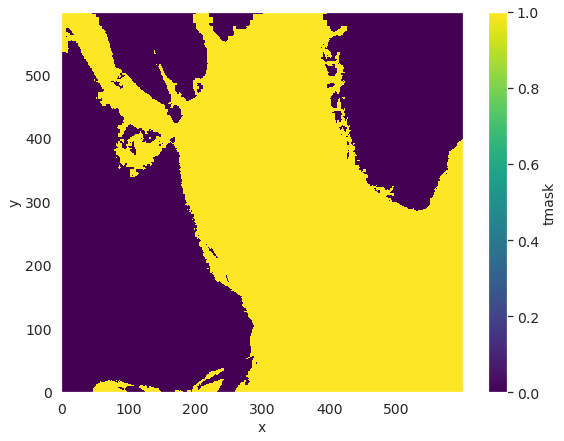

In [16]:
tmask.isel(z=10).plot()

#### Adjust section coordinates for the reduced area

In [17]:
vertices_ji = vertices_ji - np.array([ymin,xmin])
vertices_ji = vertices_ji[0:6]
print(vertices_ji)

[[ 59 270]
 [ 69 350]
 [ 95 398]
 [272 467]
 [292 499]
 [294 552]]


### Mask the calculation area

This may not exactly match the brokenline calculation along OSNAP, but it will be very close as the same OSNAP array coordinates are used.

In [18]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected while they are in a selected area.
    '''
    # particles are selected if they pass through given area.
    position =  ((lon_2 -lon_1) * (ds.nav_lat - lat_1) - 
                     (ds.nav_lon - lon_1) * (lat_2 - lat_1))
                        
    return position > 0.0, position < 0

In [19]:
# do north and south separately because of missing values

south = xr.Dataset()
north = xr.Dataset()
epsilon = 0.05
for i in range(len(lonlat.lon)-1):
    south['subsect'+str(i)],north['subsect'+str(i)] = apply_left_of_line(gridT,lonlat.lon[i+1],lonlat.lon[i],lonlat.lat[i+1]+epsilon,lonlat.lat[i]+epsilon)

# check in osnap west 
south_ow,north_ow = apply_left_of_line(gridT,-44,-44,60,30)

north_a = north.subsect0 * north.subsect1 * north.subsect2 
north_b = north.subsect3 + north.subsect4 + north.subsect5
north_all = north_ow * (north_a  + north_b)


In [20]:
north_all.compute()

<xarray.DataArray (y: 599, x: 600)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
    nav_lat  (y, x) float32 49.362778 49.366142 49.369507 ... 68.5788 68.58419
    nav_lon  (y, x) float32 -69.43258 -69.38294 ... -43.43564 -43.370003
    dim_0    int64 1
Dimensions without coordinates: y, x
Attributes:
    standard_name:  latitude
    long_name:      Latitude
    units:          degrees_north

### mask hudson bay at x = 100

In [21]:
not_hudson = (gridT.x > 100).compute()

In [22]:
gridT = gridT.rename_dims({'deptht':'z'})

In [23]:
gridT_ls = gridT.where(north_all & not_hudson & (tmask > 0.5))

In [24]:
gridT_ls

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, time_counter: 12, x: 600, y: 599, z: 46)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(148, 424), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(148, 424), meta=np.ndarray>
    deptht                (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990-12-16T12:00:00
    dim_0                 int64 1
Dimensions without coordinates: axis_nbounds, x, y, z
Data variables:
    deptht_bounds         (z, axis_nbounds, y, x) float32 dask.array<chunksize=(1, 2, 148, 424), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds, y, x, z) datetime64[ns] dask.array<chunksize=(1, 2, 148, 424, 1), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds, y, x, z) datetime64[ns] dask.array<chunksize=(1, 2, 148, 424, 1), meta=np.ndarray>
    votemper              (time_counter, z, y, x) float32 dask.array<chunksize=(1, 1, 148, 424), meta=np.ndarray>
    vosaline              (time_counter, z, y, x) float32 dask.array<chunksize=(1, 1, 148, 424), meta=np.ndarray>
    sosstsst              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sosaline              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sossheig              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    somxl010              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sowaflup              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    soshfldo              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sohefldo              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    somixhgt              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sowindsp              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sohefldp              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sowafldp              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
    sobowlin              (time_counter, y, x, z) float32 dask.array<chunksize=(1, 148, 424, 1), meta=np.ndarray>
Attributes:
    name:                      1_VIKING20X.L46-KKG36107B_1d_19900101_19900704...
    description:               ocean T grid variables
    title:                     ocean T grid variables
    Conventions:               CF-1.6
    timeStamp:                 2019-Sep-09 21:00:09 GMT
    uuid:                      6d2ef8ce-e19a-4cd5-9c73-ce86996a49da
    history:                   Tue Sep 10 18:50:03 2019: ncrcat -O -F /gfs1/w...
    NCO:                       4.4.8
    nco_openmp_thread_number:  1

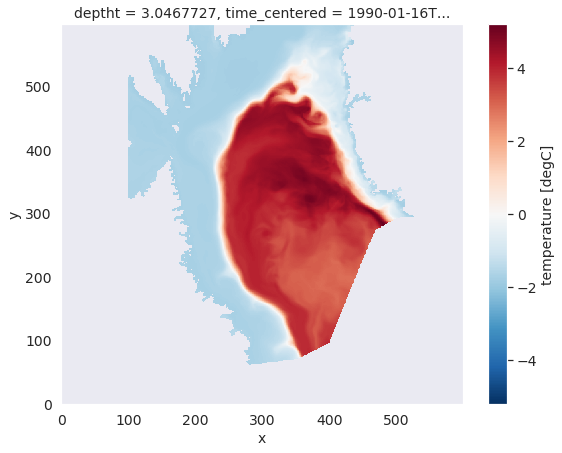

In [27]:
gridT_ls.votemper.isel(z=0,time_counter=0).plot()

### Use this apply_ufunc structure to find densities. Vectorizes the calculation and only calculates as required

In [48]:
vosigma0 = xr.apply_ufunc(
    sw.dens,
    gridT_ls.vosaline,gridT_ls.votemper,0,
    dask="parallelized",
    output_dtypes=[float, ]
)
vosigma0 = (vosigma0 - 1000.0).rename('vosigma0')


In [49]:
vosigma0

<xarray.DataArray 'vosigma0' (time_counter: 12, z: 46, y: 599, x: 600)>
dask.array<sub, shape=(12, 46, 599, 600), dtype=float64, chunksize=(1, 1, 256, 424), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(148, 424), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(148, 424), meta=np.ndarray>
    deptht         (z) float32 3.0467727 9.454049 ... 5624.9517 5875.141
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 1990-01-16T12:00:00 ... 1990-12-16T12:00:00
    dim_0          int64 1
Dimensions without coordinates: z, y, x

In [50]:
surface_area = mesh_mask.e1t*mesh_mask.e2t

## Modified this to account for surface height changes. I doubt it is significant.

In [53]:
def calculate_volumes_by_sigma0(surface_area,layer_depth,ssh,vosigma0):
    """ Calculate surface heat fluxes binned on sigma layers

    Parameters
    ----------
    heat_flux: xarray.DataArray
        DataArray containing heat fluxes [Wm^{-2}]
    surface_area: xarray.DataArray
        DataArray containing gridbox surface areas [m^2]
    sosigma0: xarray.DataArray
        DataArray containing surface sigma0
        
    Returns
    -------
    heat_flux_sigma : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins
    surface_area_sigma : xarray.Dataset
        Dataset of shape (t,sigma)
        "t" - time
        "sigma" - density bins

    """    
    deltarho = 0.01
    
    sigbins = np.arange(10,28.0001, deltarho)

    volume_by_sigma_base = histogram(vosigma0, bins=[sigbins], dim=["x","y","z"], weights=surface_area * layer_depth)
    volume_by_sigma_ssh = histogram(vosigma0.isel(z=0), bins=[sigbins], dim=["x","y"], weights=surface_area * ssh)
    volume_by_sigma = volume_by_sigma_base + volume_by_sigma_ssh
    volume_by_sigma.attrs["long_name"]='volume'
    volume_by_sigma.vosigma0_bin.attrs["long_name"]= r"$ \sigma _\theta $"
    volume_by_sigma.time_counter.attrs["long_name"]= "Date"
    volume_by_sigma.vosigma0_bin.attrs["units"]= "kg m$^{-3}$"
    volume_by_sigma.attrs["units"]='m$^3$'
    
    return volume_by_sigma

In [54]:
volume_by_sigma = calculate_volumes_by_sigma0(surface_area,mesh_mask.e3t_0,gridT.sossheig,vosigma0).compute()

In [55]:
filename_output = 'volume_by_sigma_' + mean_period + '_' + yearstr + '.nc'
volume_by_sigma.to_netcdf(path_data_output / filename_output)


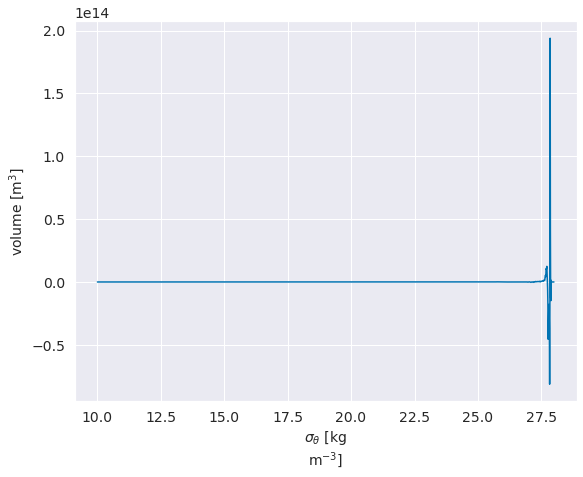

In [59]:
(volume_by_sigma.isel(time_counter=11)-volume_by_sigma.isel(time_counter=0)).plot()

In [60]:
conda list

# packages in environment at /opt/tljh/user/envs/py3_euler_brokenline_2020.08.20.1:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       0_gnu    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
basemap                   1.2.1            py37hd759880_1    conda-forge
bleach                    3.1.0                      py_0    conda-forge
blosc                     1.17.0               he1b5a44_1    conda-forge
bokeh                     1.4.0                    py37_0    conda-forge
boost-cpp                 1.70.0               h8e57a91_2    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.11.28        